# **A Sinkhorn-type algorithm for constrained optimal transport with OTT-JAX**

# **I - Introduction**

In this tutorial, we explore a new class of optimal transport (OT) problems that incorporate **equality and inequality constraints**. These constrained OT problems arise in many real-world scenarios where the transport plan must satisfy structural or operational restrictions, for example, limiting the amount of mass transported along certain routes, enforcing fairness in allocation, or incorporating domain-specific constraints such as energy, distance or ranking metrics.

We focus on the **entropically regularized** version of constrained OT, recently proposed in the paper *A Sinkhorn-type Algorithm for Constrained Optimal Transport (2024)*. This approach generalizes the classical Sinkhorn algorithm, which efficiently solves regularized OT problems via matrix scaling, to a broader class of **linearly constrained** transport problems.

The main goal of this notebook is to:
- Present the mathematical formulation of constrained OT with entropy regularization,
- Implement the Sinkhorn-type algorithm adapted to this setting using JAX and OTT,
- Illustrate its application through synthetic experiments.

This tutorial complements the existing OTT-JAX library by providing a pedagogical implementation and showcasing how constrained OT can be integrated into optimal transport pipelines.


# **II - Theoretical Background**

Let $r, c \in \mathbb{R}^n$ be two probability vectors representing the source and target distributions, and $C \in \mathbb{R}^{n \times n}$ be a cost matrix. The classical entropic optimal transport problem is defined as:

$$
\min_{P \in \mathbb{R}_+^{n \times n}} \langle C, P \rangle + \frac{1}{\eta} \sum_{i,j} P_{ij} \log P_{ij}, \quad \text{s.t. } P \mathbf{1} = r,\; P^\top \mathbf{1} = c.
$$

In the **constrained OT** setting, we further impose linear constraints on the transport matrix:

$$
\text{Find } P \in \mathbb{R}_+^{n \times n} \text{ such that }
\begin{cases}
P \mathbf{1} = r \\
P^\top \mathbf{1} = c \\
D_k \cdot P = s_k, & \forall k = 1, \dots, K \quad \text{(inequality constraints)} \\
D_{l+K} \cdot P = 0, & \forall l = 1, \dots, L \quad \text{(equality constraints)}
\end{cases}
$$

where each $D_k \in \mathbb{R}^{n \times n}$ encodes a linear constraint and $s_k \geq 0$ is a slack variable. To solve this constrained problem efficiently, we follow an **entropy-regularized** approach:

$$
\min_{P \in \mathbb{R}_+^{n \times n}, \, s_k \geq 0} \langle C, P \rangle + \frac{1}{\eta} \left( \sum_{i,j} P_{ij} \log P_{ij} + \sum_{k=1}^K s_k \log s_k \right),
\quad \text{s.t. constraints as above.}
$$

This formulation admits a **dual variational form**, with dual variables $x, y, a$ associated with marginal and constraint enforcement. The optimal transport matrix at each iteration is given by:

$$
P = \exp\left(\eta\left( -C + \sum_m a_m D_m + x \mathbf{1}^\top + \mathbf{1} y^\top \right) - 1 \right)
$$

The proposed Sinkhorn-type algorithm consists in **alternating updates** of the dual variables:
- $x$ update: enforces the row marginal constraint $P \mathbf{1} = r$,
- $y$ update: enforces the column marginal constraint $P^\top \mathbf{1} = c$,
- $a$ update: ensures feasibility with respect to the linear constraints.

We detail this algorithm and its implementation in the next section.



# **III - Implementation: Constrained Sinkhorn Solver**

We now implement the Sinkhorn-type algorithm for linearly constrained optimal transport. Our solver class follows the structure outlined in the previous section:

- At each iteration, we build the current transport plan $P$ based on dual variables $x$, $y$, and $a$.
- We update $x$ and $y$ to match the marginals via Sinkhorn-style row and column scaling.
- We update the constraint dual variables $a$ using a Newton step based on the constraint gradients and Hessian.


In [1]:
#!pip install ott-jax

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
import time

The following class `ConstrainedSinkhornSolver` implements the algorithm described in the article.

It requires :
- `C`: the cost matrix, shape (n, n), where $n$ is the number of points in the source and target distributions.
- `r` and `c`: the source and target marginals, respectively, both of shape (n,).
- `K1`: the number of inequality of the form $D_j \cdot P \geq 0$.
- `K2`: the number of inequality of the form $D_j \cdot P \leq 0$.
- `L`: the number of equality constraints of the form $D_j \cdot P = 0$.
- `D_list`: a list of $K + L$ matrices, each of shape (n, n), representing the constraints. The first $K1$ matrices are for the inequalities of the form $D_j \cdot P \geq 0$, the next $K2$ matrices are for the inequalities of the form $D_j \cdot P \leq 0$, and the last $L$ matrices are for the equalities of the form $D_j \cdot P = 0$.
- `eta`: the step size for the Sinkhorn iterations. The default value is 5.0.
- `max_iter`: the maximum number of iterations for the Sinkhorn iterations. The default value is 500.

In [4]:
rng = jax.random.PRNGKey(0)
rng1, rng2 = jax.random.split(rng, 2)
n, m, d = 3, 3, 2
x = jax.random.normal(rng1, (n, d))
y = jax.random.normal(rng2, (m, d)) + 1
a = jnp.ones(n) / n
b = jnp.ones(m) / m

In [5]:
geom = pointcloud.PointCloud(
    x=x,
    y=y,
    cost_fn=costs.Euclidean(),
    epsilon=0.1,
    # scale_cost="mean",
    relative_epsilon="mean",
)

In [6]:
geom.cost_matrix

Array([[2.4498868 , 1.5658103 , 1.0566028 ],
       [0.70741814, 2.6686075 , 1.3993815 ],
       [1.722021  , 2.077576  , 1.34883   ]], dtype=float32)

In [7]:
ot_prob = linear_problem.LinearProblem(geom, a=a, b=b)

In [8]:
ot_prob.geom

In [9]:
class ConstrainedSinkhornSolver:
    def __init__(
        self,
        prob: linear_problem.LinearProblem,
        K1: int = 0,
        K2: int = 0,
        L: int = 0,
        D_list: list[jnp.ndarray] | None = None,
        max_iter: int = 500,
    ):
        """
        Initializes the ConstrainedSinkhornSolver.

        Args:
            prob (linear_problem.LinearProblem): Linear problem instance.
            K1 (int): Number of inequality (>=) constraints.
            K2 (int): Number of inequality (<=) constraints.
            L (int): Number of equality (=) constraints.
            D_list (list[jnp.ndarray] | None): List of constraint matrices of shape (n, n).
                Ordered as [D1, D2, ..., DK1, D(K1+1), ..., D(K1+K2), D(K1+K2+1), ..., D(K1+K2+L)].
            max_iter (int): Maximum number of iterations.
        """
        self.prob = prob
        self.n = prob.geom.shape[0]
        self.C = prob.geom.cost_matrix  # (n, n)
        self.r = prob.a  # (n,)
        self.c = prob.b  # (n,)
        self.K1 = K1
        self.K2 = K2
        self.K = K1 + K2
        self.L = L
        self.J = self.K + self.L
        assert len(D_list) == self.K + self.L, "D_list must have length K + L"
        self.D_list = D_list  # J x (n, n)
        self.eta = prob.geom.epsilon
        self.max_iter = max_iter

    def compute_P(self, x: jnp.ndarray, y: jnp.ndarray, a: jnp.ndarray) -> jnp.ndarray:
        """
        Computes the transport matrix P.

        Args:
            x (jnp.ndarray): Row scaling vector of shape (n,).
            y (jnp.ndarray): Column scaling vector of shape (n,).
            a (jnp.ndarray): Constraint coefficients of shape (J,).

        Returns:
            jnp.ndarray: Transport matrix P of shape (n, n).
        """
        A = sum(a[j] * self.D_list[j] for j in range(self.J))  # (n, n)
        exponent = -self.C + A + x[:, None] + y[None, :]  # (n, n)
        return jnp.exp(self.eta * exponent - 1.0)  # (n, n)

    def row_col_scaling(
        self, P: jnp.ndarray, x: jnp.ndarray, y: jnp.ndarray, a: jnp.ndarray
    ) -> jnp.ndarray:
        """
        Performs row and column scaling on the transport matrix P.

        Args:
            P (jnp.ndarray): Transport matrix of shape (n, n).
            x (jnp.ndarray): Row scaling vector of shape (n,).
            y (jnp.ndarray): Column scaling vector of shape (n,).
            a (jnp.ndarray): Constraint coefficients of shape (J,).

        Returns:
            tuple: Updated transport matrix P, row scaling vector x, and column scaling vector y.
        """
        u = self.r / (jnp.sum(P, axis=1) + 1e-10)  # (n,)
        x = x + jnp.log(u) / self.eta  # (n,)
        P = self.compute_P(x, y, a)  # (n, n)
        v = self.c / (jnp.sum(P, axis=0) + 1e-10)  # (n,)
        y = y + jnp.log(v) / self.eta  # (n,)
        return self.compute_P(x=x, y=y, a=a), x, y

    def constraint_grad(self, P: jnp.ndarray) -> jnp.ndarray:
        """
        Computes the gradient of the constraint.

        Args:
            P (jnp.ndarray): Transport matrix of shape (n, n).

        Returns:
            jnp.ndarray: Gradient of the constraint of shape (J,).
        """
        return jnp.array([jnp.sum(D * P) for D in self.D_list])  # (J,)

    def constraint_hessian(self, P: jnp.ndarray) -> jnp.ndarray:
        """
        Computes the Hessian of the constraint.

        Args:
            P (jnp.ndarray): Transport matrix of shape (n, n).

        Returns:
            jnp.ndarray: Hessian of the constraint of shape (J, J).
        """
        return jnp.array(
            [[jnp.sum(D1 * D2 * P) for D2 in self.D_list] for D1 in self.D_list]
        )  # (J, J)

    def constraint_update_step(
        self, grad: jnp.ndarray, hessian: jnp.ndarray
    ) -> jnp.ndarray:
        """
        Computes the Hessian of the constraint.

        Args:
            P (jnp.ndarray): Transport matrix of shape (n, n).

        Returns:
            jnp.ndarray: Hessian of the constraint of shape (J, J).
        """
        return jax.scipy.linalg.solve(a=hessian, b=-grad, assume_a="pos")  # (J,)

    def constraint_t_update(self, P: jnp.ndarray, x: jnp.ndarray) -> jnp.ndarray:
        """
        Updates the row scaling vector x based on the transport matrix P.

        Args:
            P (jnp.ndarray): Transport matrix of shape (n, n).
            x (jnp.ndarray): Row scaling vector of shape (n,).

        Returns:
            jnp.ndarray: Updated row scaling vector x of shape (n,).
        """
        return x - jnp.sum(P, axis=1) + self.r  # (n,)

    def constraint_projection(self, a: jnp.ndarray) -> jnp.ndarray:
        """
        Projects the constraint coefficients onto the feasible set.

        Args:
            a (jnp.ndarray): Constraint coefficients of shape (J,).

        Returns:
            jnp.ndarray: Projected constraint coefficients of shape (J,).
        """
        for k in range(self.K):
            if k < self.K1:
                a = a.at[k].set(jnp.maximum(a[k], 0.0))
            elif k < self.K:
                a = a.at[k].set(jnp.minimum(a[k], 0.0))
        return a

    def solve(self) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        """
        Solves the constrained Sinkhorn problem.

        Returns:
            tuple: Transport matrix P, row scaling vector x, column scaling vector y, and constraint coefficients a.
        """
        start_time = time.time()
        x = jnp.zeros(self.n)  # (n,)
        y = jnp.zeros(self.n)  # (n,)
        a = jnp.zeros(self.J)  # (J,)

        for _ in range(self.max_iter):
            P = self.compute_P(x=x, y=y, a=a)  # (n, n)
            P, x, y = self.row_col_scaling(P=P, x=x, y=y, a=a)
            grad = self.constraint_grad(P=P)  # (J,)
            hess = self.constraint_hessian(P=P) + 1e-8 * jnp.eye(self.J)  # (J, J)
            a += self.constraint_update_step(grad=grad, hessian=hess)  # (J,)
            x = self.constraint_t_update(P=P, x=x)  # (n,)
            a = self.constraint_projection(a=a)  # (J,)
        print(f"Time taken for solving: {time.time() - start_time:.2f} seconds")
        return P, x, y, a

## **IV - Illustration**

Let's consider a simple example : we have $n$ mines and $n$ factories, and we need to ship production from mines to factories. The cost of shipping from mine $i$ to factory $j$ is given by the matrix $C$. The supply of mines is given by the vector $r$ and the demand of factories is given by the vector $c$. We want to find the optimal shipment plan that minimizes the total cost.

We first need some utils functions.

In [10]:
def plot_weighted_points(
    ax: plt.Axes,
    X: jnp.ndarray,
    a: jnp.ndarray,
    Y: jnp.ndarray,
    b: jnp.ndarray,
    title: str | None = None,
    X_label: str | None = None,
    Y_label: str | None = None,
):
    """
    Plots weighted points on a given axis.

    Args:
        ax (plt.Axes): The axis on which to plot.
        X (jnp.ndarray): Coordinates of the first set of points of shape (n, 2).
        a (jnp.ndarray): Weights for the first set of points of shape (n,).
        Y (jnp.ndarray): Coordinates of the second set of points of shape (m, 2).
        b (jnp.ndarray): Weights for the second set of points of shape (m,).
        title (str, optional): Title of the plot. Default is None.
        X_label (str, optional): Label for the first set of points. Default is None.
        Y_label (str, optional): Label for the second set of points. Default is None.
    """
    size_scale = 1500
    ax.scatter(
        X[:, 0],
        X[:, 1],
        s=size_scale * a,
        c="red",
        edgecolors="k",
        alpha=0.9,
        label=X_label,
    )
    ax.scatter(
        Y[:, 0],
        Y[:, 1],
        s=size_scale * b,
        c="blue",
        edgecolors="k",
        alpha=0.9,
        label=Y_label,
    )
    for i in range(jnp.shape(X)[0]):
        ax.annotate(
            str(i + 1),
            (X[i, 0], X[i, 1]),
            textcoords="offset points",
            xytext=(0, -5),
            ha="center",
            fontsize=15,
            color="black",
        )
    for i in range(jnp.shape(Y)[0]):
        ax.annotate(
            str(i + 1),
            (Y[i, 0], Y[i, 1]),
            textcoords="offset points",
            xytext=(0, -5),
            ha="center",
            fontsize=15,
            color="black",
        )
    if X_label is not None or Y_label is not None:
        ax.legend(fontsize=12, markerscale=0.5)
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=15)
    ax.margins(0.1)


def plot_assignement(
    ax: plt.Axes,
    X: jnp.ndarray,
    a: jnp.ndarray,
    Y: jnp.ndarray,
    b: jnp.ndarray,
    optimal_plan: jnp.ndarray,
    title: str | None = None,
    X_label: str | None = None,
    Y_label: str | None = None,
):
    """
    Plots the assignment between two sets of weighted points.

    Args:
        ax (matplotlib.axes.Axes): The axis on which to plot.
        X (np.ndarray): Coordinates of the first set of points of shape (n, 2).
        a (np.ndarray): Weights for the first set of points of shape (n,).
        Y (np.ndarray): Coordinates of the second set of points of shape (m, 2).
        b (np.ndarray): Weights for the second set of points of shape (m,).
        optimal_plan (np.ndarray): Optimal assignment plan of shape (n, m).
        title (str, optional): Title of the plot. Default is None.
        X_label (str, optional): Label for the first set of points. Default is None.
        Y_label (str, optional): Label for the second set of points. Default is None.
    """
    plot_weighted_points(
        ax=ax, X=X, a=a, Y=Y, b=b, title=None, X_label=X_label, Y_label=Y_label
    )
    for i in range(optimal_plan.shape[0]):
        for j in range(optimal_plan.shape[1]):
            ax.plot(
                [X[i, 0], Y[j, 0]],
                [X[i, 1], Y[j, 1]],
                c="k",
                lw=10 * optimal_plan[i, j],
                alpha=0.8,
            )
    ax.axis("off")
    ax.set_title(title, fontsize=15)


def plot_transport_plan(ax, P: jnp.ndarray, title: str, color: str = "Greens") -> None:
    """
    Plots the transport plan as a heatmap.

    Args:
        P (jnp.ndarray): Transport matrix of shape (n, n).
        title (str): Title of the plot.
        color (str): Color map for the heatmap. Default is "Greens".
    """
    n = P.shape[0]
    cax = ax.imshow(np.array(P), cmap=color)
    ax.set_title(title, fontsize=15)
    fig = ax.get_figure()
    fig.colorbar(cax, ax=ax)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels([f"Factory {i}" for i in range(1, n + 1)])
    ax.set_yticklabels([f"Mine {i}" for i in range(1, n + 1)])
    for i in range(n):
        for j in range(n):
            ax.text(j, i, f"{P[i, j]:.2f}", ha="center", va="center", color="black")


def print_results(
    P_constrained: jnp.ndarray,
    P_unconstrained: jnp.ndarray,
    list_D: list[jnp.ndarray],
    constraints_names: list[str],
    solver: ConstrainedSinkhornSolver,
) -> None:
    """
    Prints the results of the constrained and unconstrained transport plans.

    Args:
        P_constrained (jnp.ndarray): Constrained transport matrix of shape (n, n).
        P_unconstrained (jnp.ndarray): Unconstrained transport matrix of shape (n, n).
        list_D (list[jnp.ndarray]): List of constraint matrices of shape (n, n).
        constraints_names (list[str]): List of constraint names.
        solver (ConstrainedSinkhornSolver): Solver instance.
    """
    print("\n--- Cost ---")
    print("The objective is to minimize the cost.")
    print(f"Unconstrained cost: {jnp.sum(P_unconstrained * solver.C):.2f}")
    print(f"Constrained cost: {jnp.sum(P_constrained * solver.C):.2f}")
    print("\n--- Marginals ---")
    print("The objective is to be equal to the marginals.")
    print(f"r: {solver.r}")
    print(f"c: {solver.c}")
    print("Unconstrained :")
    print(f"r': {jnp.sum(P_unconstrained, axis=1)}")
    print(f"c': {jnp.sum(P_unconstrained, axis=0)}")
    print("Constrained :")
    print(f"r'': {jnp.sum(P_constrained, axis=1)}")
    print(f"c'': {jnp.sum(P_constrained, axis=0)}")
    print("\n--- Constraints ---")
    print("The objective is to respect the constraints.")
    print("Unconstrained :")
    for name, D in zip(constraints_names, list_D):
        constraint_value = jnp.sum(P_unconstrained * D)
        message = (
            "(should be equal to 0)"
            if name == "D_1"
            else "(should be greater or equal than 0)"
        )
        print(f"Constraint {name} : {constraint_value:.2f} {message}")
    print("Constrained :")
    for name, D in zip(constraints_names, list_D):
        constraint_value = jnp.sum(P_constrained * D)
        message = (
            "(should be equal to 0)"
            if name == "D_1"
            else "(should be greater or equal than 0)"
        )
        print(f"Constraint {name} : {constraint_value:.2f} {message}")
    print("\n")
    return None

We can now generate random points and initialize a `ott.geometry.pointcloud.PointCloud` instance.

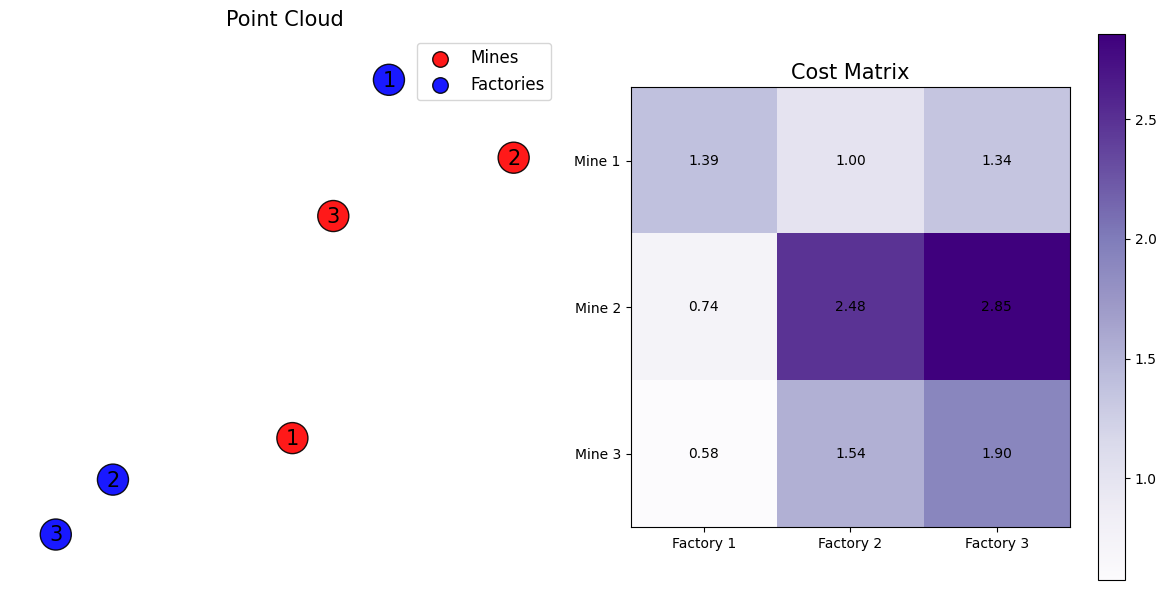

In [11]:
eta = 5.0
rng = jax.random.PRNGKey(42)
rng1, rng2 = jax.random.split(rng, 2)
n, d = 3, 2
x = jax.random.normal(rng1, (n, d))  # (n, d)
y = jax.random.normal(rng2, (n, d))  # (n, d)
r = jnp.ones(n) / n  # (n,)
c = jnp.ones(n) / n  # (n,)
geom = pointcloud.PointCloud(
    x=x,
    y=y,
    cost_fn=costs.Euclidean(),
    epsilon=eta,
    relative_epsilon=None,
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_weighted_points(
    ax=ax[0],
    X=x,
    a=r,
    Y=y,
    b=c,
    title="Point Cloud",
    X_label="Mines",
    Y_label="Factories",
)
plot_transport_plan(ax=ax[1], P=geom.cost_matrix, title="Cost Matrix", color="Purples")
plt.tight_layout()
plt.show()

Then, we can define a `ott.problems.linear.linear_problem` instance and solve it with our `ConstrainedSinkhornSolver` class.

Time taken for solving: 1.88 seconds


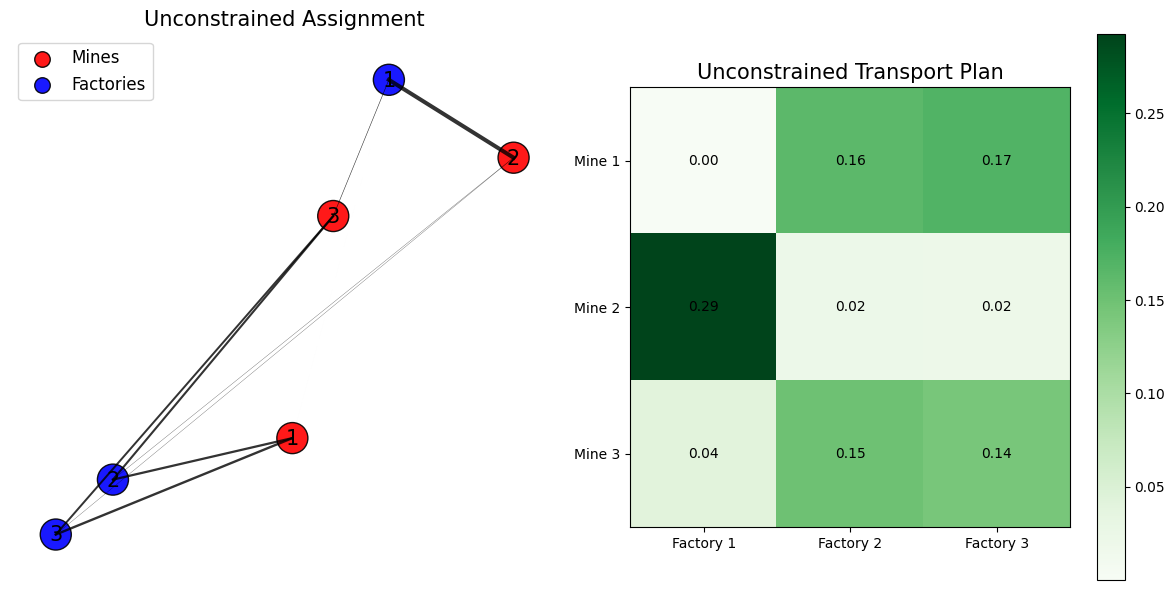

In [12]:
prob = linear_problem.LinearProblem(geom=geom, a=r, b=c)
solver_unconstrained = ConstrainedSinkhornSolver(prob=prob, K1=0, K2=0, L=0, D_list=[])
P_unconstrained, _, _, _ = solver_unconstrained.solve()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_assignement(
    ax=ax[0],
    X=x,
    a=r,
    Y=y,
    b=c,
    optimal_plan=P_unconstrained,
    title="Unconstrained Assignment",
    X_label="Mines",
    Y_label="Factories",
)
plot_transport_plan(ax=ax[1], P=P_unconstrained, title="Unconstrained Transport Plan")
plt.tight_layout()
plt.show()

Now, let's consider the case where we have some constraints on the transport plan.

First, let's assume that a problem occurs and we can no longer ship from mine 2 to factory 1. We need to add a constraint and set the corresponding entry in the transport plan to 0.

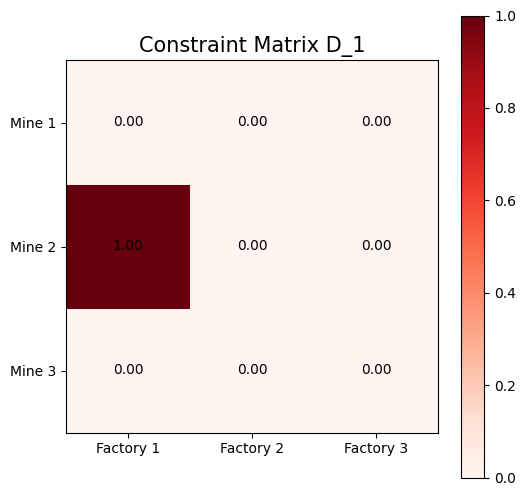

In [13]:
D_1 = jnp.zeros((n, n))  # (n, n)
D_1 = D_1.at[1, 0].set(1)  # (n, n)
fig, ax = plt.subplots(figsize=(6, 6))
plot_transport_plan(
    ax=ax,
    P=D_1,
    title=r"Constraint Matrix D_1",
    color="Reds",
)

Now, let's solve this problem with the added constraint.

Time taken for solving: 2.50 seconds

--- Cost ---
The objective is to minimize the cost.
Unconstrained cost: 1.24
Constrained cost: 1.49

--- Marginals ---
The objective is to be equal to the marginals.
r: [0.33333334 0.33333334 0.33333334]
c: [0.33333334 0.33333334 0.33333334]
Unconstrained :
r': [0.33333337 0.3333333  0.33333334]
c': [0.33333334 0.33333334 0.3333333 ]
Constrained :
r'': [0.3333333  0.33333325 0.3333334 ]
c'': [0.33333334 0.3333333  0.33333334]

--- Constraints ---
The objective is to respect the constraints.
Unconstrained :
Constraint D_1 : 0.29 (should be equal to 0)
Constrained :
Constraint D_1 : 0.00 (should be equal to 0)




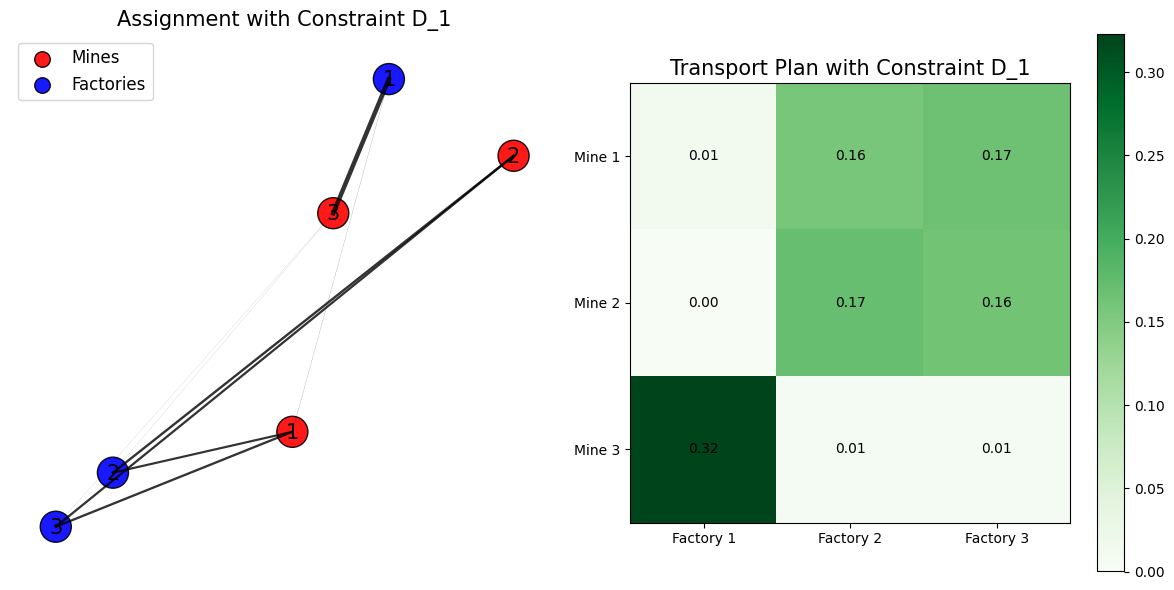

In [14]:
solver_1 = ConstrainedSinkhornSolver(prob=prob, K1=0, K2=0, L=1, D_list=[D_1])
P_1, _, _, _ = solver_1.solve()
print_results(
    P_constrained=P_1,
    P_unconstrained=P_unconstrained,
    list_D=[D_1],
    constraints_names=["D_1"],
    solver=solver_1,
)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_assignement(
    ax=ax[0],
    X=x,
    a=r,
    Y=y,
    b=c,
    optimal_plan=P_1,
    title="Assignment with Constraint D_1",
    X_label="Mines",
    Y_label="Factories",
)
plot_transport_plan(ax=ax[1], P=P_1, title="Transport Plan with Constraint D_1")
plt.tight_layout()
plt.show()

As we can see, as mine 1 can no longer ship its production to factory 1, it now ships to factory 2.

On the other side, mine 2 has to ship its production to factory 1 to satisfy the demand.

Despite increasing the cost of the transport plan, we are now able to deal with this constraint, conrary to the basic Sinkhorn algorithm.

Now, let's assume that, contrary to the previous equality constraint, we now have an inequality constraint. Let's assume that mine 1 and factory 1 set up a partnership, meaning that mine 1 has to ship at least 1/2 of its production (i.e. 1/6 of total production) to factory 1.

We need to create a new constraint.

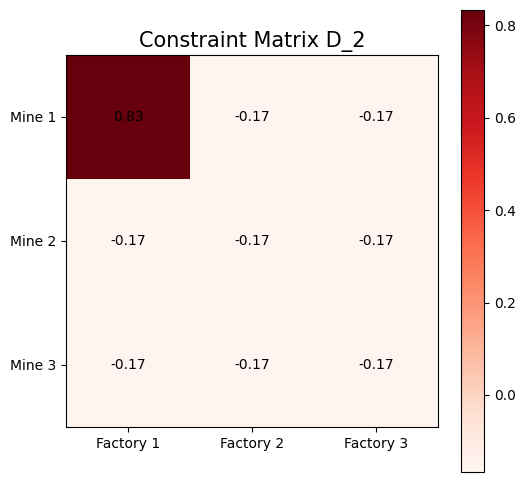

In [15]:
D_2 = jnp.zeros((n, n))  # (n, n)
D_2 = D_2.at[0, 0].set(1)  # (n, n)
D_2 = D_2 - 1 / 6  # (n, n)
fig, ax = plt.subplots(figsize=(6, 6))
plot_transport_plan(
    ax=ax,
    P=D_2,
    title=r"Constraint Matrix D_2",
    color="Reds",
)

We can now solve the problem with the new constraint.

Time taken for solving: 3.18 seconds

--- Cost ---
The objective is to minimize the cost.
Unconstrained cost: 1.24
Constrained cost: 1.57

--- Marginals ---
The objective is to be equal to the marginals.
r: [0.33333334 0.33333334 0.33333334]
c: [0.33333334 0.33333334 0.33333334]
Unconstrained :
r': [0.33333337 0.3333333  0.33333334]
c': [0.33333334 0.33333334 0.3333333 ]
Constrained :
r'': [0.3333333 0.3333333 0.3333333]
c'': [0.3333333  0.33333334 0.33333325]

--- Constraints ---
The objective is to respect the constraints.
Unconstrained :
Constraint D_2 : -0.17 (should be greater or equal than 0)
Constrained :
Constraint D_2 : 0.00 (should be greater or equal than 0)




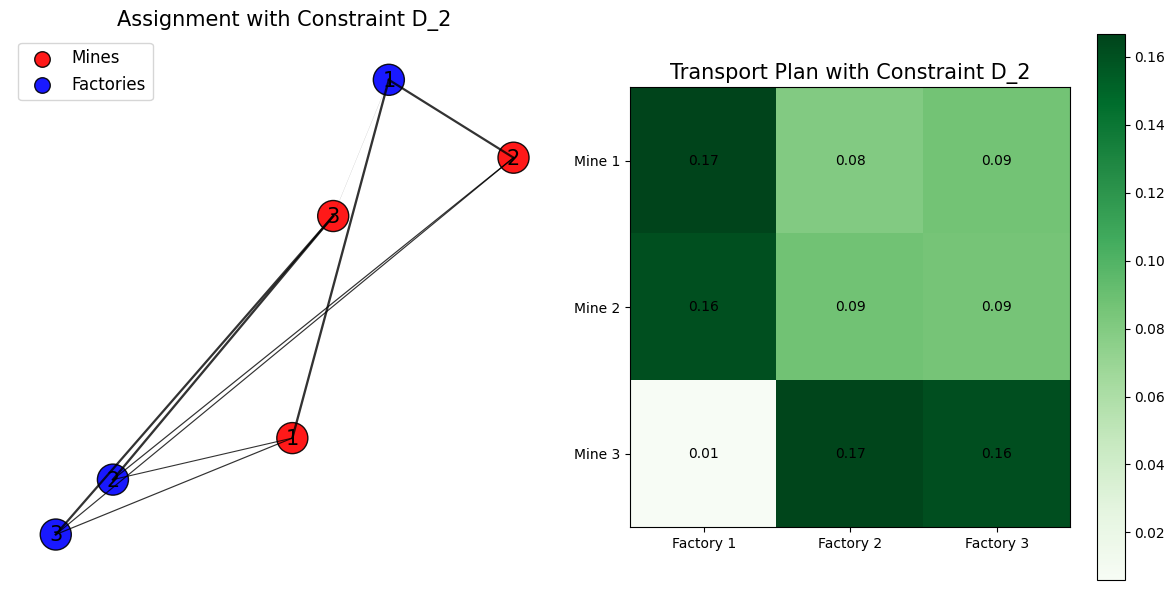

In [16]:
solver_2 = ConstrainedSinkhornSolver(prob=prob, K1=1, K2=0, L=0, D_list=[D_2])
P_2, _, _, _ = solver_2.solve()
print_results(
    P_constrained=P_2,
    P_unconstrained=P_unconstrained,
    list_D=[D_2],
    constraints_names=["D_2"],
    solver=solver_2,
)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_assignement(
    ax=ax[0],
    X=x,
    a=r,
    Y=y,
    b=c,
    optimal_plan=P_2,
    title="Assignment with Constraint D_2",
    X_label="Mines",
    Y_label="Factories",
)
plot_transport_plan(ax=ax[1], P=P_2, title="Transport Plan with Constraint D_2")
plt.tight_layout()
plt.show()

Here again, the transport plan has to change to adapt to the constraint.

The new transport plan is more expensive but satisfies the constraint.

Finally, let's assume that both constraints are active.

Time taken for solving: 5.14 seconds

--- Cost ---
The objective is to minimize the cost.
Unconstrained cost: 1.24
Constrained cost: 1.70

--- Marginals ---
The objective is to be equal to the marginals.
r: [0.33333334 0.33333334 0.33333334]
c: [0.33333334 0.33333334 0.33333334]
Unconstrained :
r': [0.33333337 0.3333333  0.33333334]
c': [0.33333334 0.33333334 0.3333333 ]
Constrained :
r'': [0.3333333  0.3333335  0.33333325]
c'': [0.33333334 0.3333333  0.33333337]

--- Constraints ---
The objective is to respect the constraints.
Unconstrained :
Constraint D_1 : 0.29 (should be equal to 0)
Constraint D_2 : -0.17 (should be greater or equal than 0)
Constrained :
Constraint D_1 : 0.00 (should be equal to 0)
Constraint D_2 : 0.00 (should be greater or equal than 0)




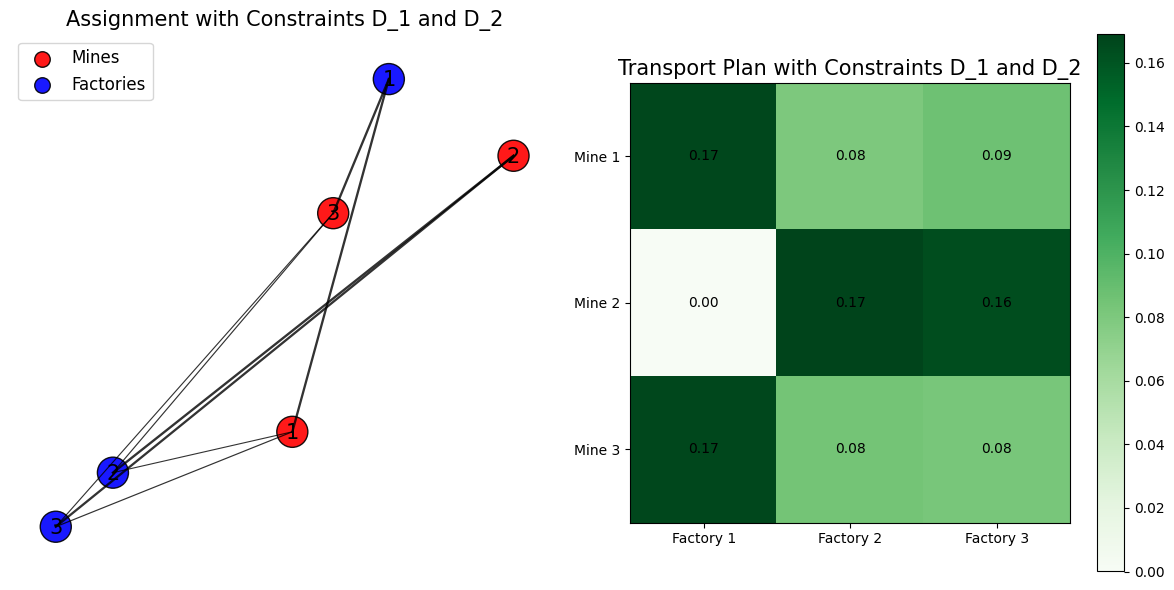

In [17]:
solver_3 = ConstrainedSinkhornSolver(prob=prob, K1=1, K2=0, L=1, D_list=[D_2, D_1])
P_3, _, _, _ = solver_3.solve()
print_results(
    P_constrained=P_3,
    P_unconstrained=P_unconstrained,
    list_D=[D_1, D_2],
    constraints_names=["D_1", "D_2"],
    solver=solver_3,
)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_assignement(
    ax=ax[0],
    X=x,
    a=r,
    Y=y,
    b=c,
    optimal_plan=P_3,
    title="Assignment with Constraints D_1 and D_2",
    X_label="Mines",
    Y_label="Factories",
)
plot_transport_plan(
    ax=ax[1], P=P_3, title="Transport Plan with Constraints D_1 and D_2"
)
plt.tight_layout()
plt.show()

Hence, our algorithm is able to deal with multiple constraints at the same time, and to find a transport plan that best satisfy them while minimizing the transport cost.

## **V - Experiments**

### **V.1 - Random Assignment with Symmetric Linear Constraints**

The objective of this experiment is to look at the evolution of the performance of the algorithm (both in terms of cost and constraint violation) throughout the iterations.

In this experiment, we simulate a random assignment problem between two uniform distributions of size $n = 500$.

- The cost matrix $C \in \mathbb{R}^{n \times n}$ is sampled from a uniform distribution $\mathcal{U}[0, 1]$ and normalized.
- The marginals $r$ and $c$ are both set to $\frac{1}{n} \mathbf{1}_n$.
- The matrix $D_I \in \mathbb{R}^{n \times n}$ is sampled from a uniform distribution $\mathcal{U}[0, 1]$ and is used for the constraint $P \cdot D_I \leq \frac{1}{2}$.
- The matrix $D_E \in \mathbb{R}^{n \times n}$ is sampled from a uniform distribution $\mathcal{U}[0, 1]$ and is used for the constraint $P \cdot D_E = \frac{1}{2}$.

We solve the constrained entropic OT problem using our `ConstrainedSinkhornSolver`.

However, at each iteration $t$, we evaluate the performance on the projected transport matrix $\hat{P}^{(t)}$, obtained by applying a bistochastic rounding procedure:
- The **cost** is computed as $\text{Cost}^{(t)} = \langle C, \hat{P}^{(t)} \rangle$.
- The **constraint violation** is measured as:
  $$
  \text{Violation}^{(t)} = \sum_{k=1}^{K} \left| D_k \cdot \hat{P}^{(t)} \right|
  $$

This rounding step ensures fair comparison across iterations, by evaluating each plan inside the transport polytope $\mathcal{U}_{r,c}$.


First, we modify `ConstrainedSinkhornSolver` to include the evaluation step at each iteration. We call this new class `EvaluatedConstrainedSinkhornSolver`."""

In [18]:
class EvaluatedConstrainedSinkhornSolver(ConstrainedSinkhornSolver):
    def __init__(
        self,
        prob: linear_problem.LinearProblem,
        K1: int = 0,
        K2: int = 0,
        L: int = 0,
        D_list: list[jnp.ndarray] | None = None,
        max_iter: int = 500,
    ):
        """
        Initializes the ConstrainedSinkhornSolver.

        Args:
            prob (linear_problem.LinearProblem): Linear problem instance.
            K1 (int): Number of inequality (>=) constraints.
            K2 (int): Number of inequality (<=) constraints.
            L (int): Number of equality (=) constraints.
            D_list (list[jnp.ndarray] | None): List of constraint matrices of shape (n, n).
                Ordered as [D1, D2, ..., DK1, D(K1+1), ..., D(K1+K2), D(K1+K2+1), ..., D(K1+K2+L)].
            max_iter (int): Maximum number of iterations.
        """
        super().__init__(
            prob=prob,
            K1=K1,
            K2=K2,
            L=L,
            D_list=D_list,
            max_iter=max_iter,
        )

    def project_to_bistochastic(self, P: jnp.ndarray, n_iter: int = 10) -> jnp.ndarray:
        """
        Projects the transport matrix to a bistochastic matrix using alternate projections (Altschuler et al. 2017).

        Args:
            P (jnp.ndarray): Transport matrix of shape (n, n).
            n_iter (int): Number of iterations for projection. Default is 10.

        Returns:
            jnp.ndarray: Bistochastic transport matrix of shape (n, n)."""
        for _ in range(n_iter):
            P = P * (self.r / (jnp.sum(P, axis=1) + 1e-10))[:, None]  # (n, n)
            P = P * (self.c / (jnp.sum(P, axis=0) + 1e-10))[None, :]  # (n, n)
        return P  # (n, n))

    def constraint_violation(self, P: jnp.ndarray) -> float:
        """
        Calculates the total constraint violation.

        Args:
            P (jnp.ndarray): Transport matrix of shape (n, n).

        Returns:
            float: Total constraint violation.
        """
        term_geq = float(
            sum(
                jnp.abs(jnp.minimum(jnp.sum(D * P), 0.0))
                for D in self.D_list[: self.K1]
            )
        )
        term_leq = float(
            sum(
                jnp.abs(jnp.maximum(jnp.sum(D * P), 0.0))
                for D in self.D_list[self.K1 : self.K]
            )
        )
        term_eq = float(sum(jnp.abs(jnp.sum(D * P)) for D in self.D_list[self.K :]))
        return float(term_geq + term_leq + term_eq)

    def cost(self, P: jnp.ndarray) -> float:
        """
        Calculates the cost of the transport matrix.

        Args:
            P (jnp.ndarray): Transport matrix of shape (n, n).

        Returns:
            float: Total cost.
        """
        return float(jnp.sum(self.C * P))

    def solve(
        self,
    ) -> tuple[
        jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray, list[float], list[float]
    ]:
        """
        Solves the constrained Sinkhorn problem and evaluates the solution.

        Returns:
            tuple: Transport matrix P, row scaling vector x, column scaling vector y, constraint coefficients a,
                list of costs, and list of constraint violations.
        """
        start_time = time.time()
        x = jnp.zeros(self.n)  # (n,)
        y = jnp.zeros(self.n)  # (n,)
        a = jnp.zeros(self.J)  # (K,)
        cost_list = []
        violation_list = []
        for _ in range(self.max_iter):
            P = self.compute_P(x=x, y=y, a=a)  # (n, n)
            P, x, y = self.row_col_scaling(P=P, x=x, y=y, a=a)
            grad = self.constraint_grad(P=P)  # (J,)
            hess = self.constraint_hessian(P=P) + 1e-8 * jnp.eye(self.J)  # (J, J)
            a += self.constraint_update_step(grad=grad, hessian=hess)  # (J,)
            x = self.constraint_t_update(P=P, x=x)  # (n,)
            a = self.constraint_projection(a=a)  # (J,)
            P_proj = self.project_to_bistochastic(P=P)  # (n, n)
            cost_list.append(self.cost(P=P_proj))
            violation_list.append(self.constraint_violation(P=P_proj))
        print(f"Time taken for solving: {time.time() - start_time:.2f} seconds")
        return P, x, y, a, cost_list, violation_list

Then, we define the inputs of the experiment.

In [19]:
eta = 1200.0
max_iter = 100
rng = jax.random.PRNGKey(42)
rng1, rng2 = jax.random.split(rng, 2)
n = 500
r = jnp.ones(n) / n  # (n,)
c = jnp.ones(n) / n  # (n,)
C = jax.random.uniform(rng, shape=(n, n))  # (n, n)
geom = ott.geometry.geometry.Geometry(cost_matrix=C, epsilon=eta)
prob = linear_problem.LinearProblem(geom=geom, a=r, b=c)
D_G = jax.random.uniform(rng1, shape=(n, n))  # (n, n)
D_E = jax.random.uniform(rng2, shape=(n, n))  # (n, n)
t_G = 0.5
t_E = 0.5
D_1 = (D_G - t_G) / n  # (n, n)
D_2 = (D_E - t_E) / n  # (n, n)

We can solve the problem and plot the results.

Time taken for solving: 5.62 seconds


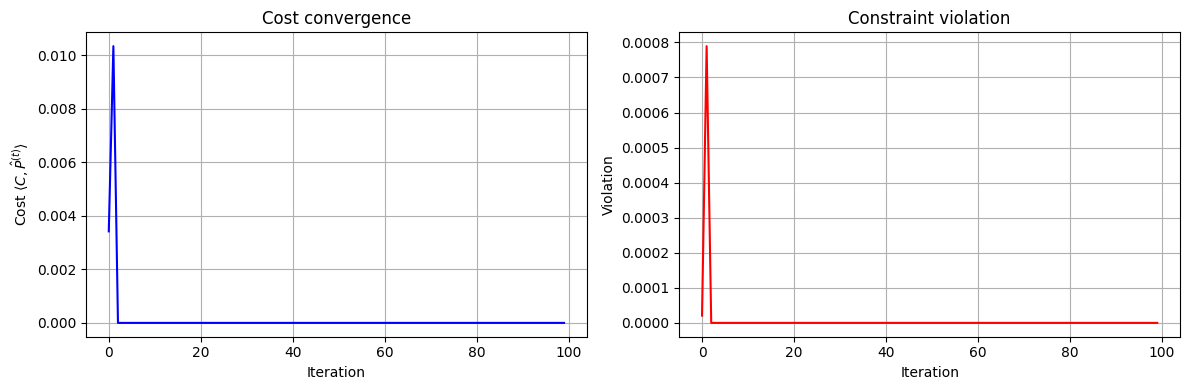

In [20]:
solver = EvaluatedConstrainedSinkhornSolver(
    prob=prob, K1=0, K2=1, L=1, D_list=[D_1, D_2], max_iter=max_iter
)
_, _, _, _, cost_list, violation_list = solver.solve()


def plot_graph(lst: list[float], title: str, ylabel: str, color: str) -> None:
    """
    Plots a graph of a list of values.

    Args:
        lst (list[float]): List of values to plot.
        title (str): Title of the plot.
        ylabel (str): Label for the y-axis.
        color (str): Color of the plot.
    """
    plt.plot(lst, color=color)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.grid(True)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_graph(
    lst=cost_list,
    title="Cost convergence",
    ylabel="Cost $\\langle C, \\hat{P}^{(t)} \\rangle$",
    color="blue",
)
plt.subplot(1, 2, 2)
plot_graph(
    lst=violation_list, title="Constraint violation", ylabel="Violation", color="red"
)
plt.tight_layout()
plt.show()

As we can see, the solver quickly converges to a solution that respect the constraint while minimizing the cost.

### **V.2 - MNIST: Forbid a Square Region**

In this experiment, we apply constrained optimal transport on two MNIST digits.

- We select two images (source and target) and normalize them into probability distributions.
- We define a pixel-wise cost matrix using the squared Euclidean distance.
- We introduce a linear constraint that **forbids mass transport** toward a square region (e.g., the center of the target image).
- We solve the constrained entropic OT problem using our `ConstrainedSinkhornSolver`.
- Finally, we visualize the transported image and overlay the forbidden zone in red.

This setup allows us to observe how the constraint modifies the optimal plan, forcing the transport to bypass the restricted region.

In [21]:
from tensorflow.keras.datasets import mnist

First, let's define some utils functions.

In [22]:
def normalize(img: np.ndarray) -> jnp.ndarray:
    """
    Normalizes an image by converting it to a probability distribution.

    Args:
        img (np.ndarray): Input image of shape (n_rows, n_cols).

    Returns:
        jnp.ndarray: Normalized image vector of shape (n_rows * n_cols,).
    """
    vec = jnp.ravel(img.astype(jnp.float32))
    vec = jnp.maximum(vec, 1e-6)
    return vec / jnp.sum(vec)


def create_C(n_rows: int = 28, n_cols: int = 28) -> jnp.ndarray:
    """
    Creates a cost matrix based on Euclidean distances between pixel coordinates.

    Args:
        n_rows (int): Number of rows in the image. Default is 28.
        n_cols (int): Number of columns in the image. Default is 28.

    Returns:
        jnp.ndarray: Cost matrix of shape (n_rows * n_cols, n_rows * n_cols).
    """
    coords = jnp.array([(i, j) for i in range(n_rows) for j in range(n_cols)])
    dist = jnp.sum((coords[:, None, :] - coords[None, :, :]) ** 2, axis=-1)
    return dist / jnp.max(dist)


def create_D(n_rows: int = 28, n_cols: int = 28) -> jnp.ndarray:
    """
    Creates a constraint matrix with a forbidden zone.

    Args:
        n_rows (int): Number of rows in the image. Default is 28.
        n_cols (int): Number of columns in the image. Default is 28.

    Returns:
        jnp.ndarray: Constraint matrix of shape (n_rows * n_cols, n_rows * n_cols).
    """
    mask = jnp.ones((n_rows, n_cols))
    mask = mask.at[5:15, 5:15].set(0.0)
    forbidden = (1.0 - mask).reshape(784)
    D = jnp.ones((784, 1)) @ forbidden[None, :]
    return D


def check_constraint(P: jnp.ndarray, D: jnp.ndarray) -> None:
    """
    Checks the constraint violation by computing the absolute sum of the element-wise product of P and D.

    Args:
        P (jnp.ndarray): Transport matrix of shape (n_rows * n_cols, n_rows * n_cols).
        D (jnp.ndarray): Constraint matrix of shape (n_rows * n_cols, n_rows * n_cols).
    """
    print("|D . P| =", jnp.sum(jnp.abs(D * P)))
    print("\n")


def plot_image(img: np.ndarray | jnp.ndarray, title: str = "") -> None:
    """
    Plots an image with a specified title.

    Args:
        img (np.ndarray | jnp.ndarray): Input image of shape (n_rows, n_cols).
        title (str): Title of the plot. Default is an empty string.
    """
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])


def plot_overlay() -> None:
    """
    Plots an overlay with a forbidden zone.
    """
    overlay = jnp.zeros((28, 28, 4))
    overlay = overlay.at[5:15, 5:15, 0].set(1.0)
    overlay = overlay.at[5:15, 5:15, 3].set(0.5)
    plt.imshow(np.array(overlay), interpolation="none")


def plot_images(A: np.ndarray, B: np.ndarray, img_out: np.ndarray) -> None:
    """
    Plots the source image, target image, and transported image with an overlay.

    Args:
        A (np.ndarray): Source image of shape (n_rows, n_cols).
        B (np.ndarray): Target image of shape (n_rows, n_cols).
        img_out (np.ndarray): Transported image of shape (n_rows, n_cols).
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plot_image(A, "Source image A")
    plt.subplot(1, 4, 2)
    plot_image(B, "Target image B")
    plt.subplot(1, 4, 4)
    plot_image(img_out, "Transported image")
    plt.subplot(1, 4, 3)
    plot_image(B, "Target image with forbidden zone")
    plot_overlay()
    plt.tight_layout()
    plt.show()

Now, let's solve the transport problem with the constraint.

In [23]:
eta = 20.0
(x_train, _), _ = mnist.load_data()
A = x_train[0]  # (28, 28)
B = x_train[1]  # (28, 28)
r = normalize(A)  # (784,)
c = normalize(B)  # (784,)
C = create_C()  # (784, 784)
geom = ott.geometry.geometry.Geometry(cost_matrix=C, epsilon=eta)
prob = linear_problem.LinearProblem(geom, a=r, b=c)
D = create_D()  # (784, 784)

solver = ConstrainedSinkhornSolver(prob=prob, K1=0, K2=0, L=1, D_list=[D])

P, _, _, _ = solver.solve()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Time taken for solving: 14.60 seconds


Let's check the solution.

|D . P| = 1.199161e-07




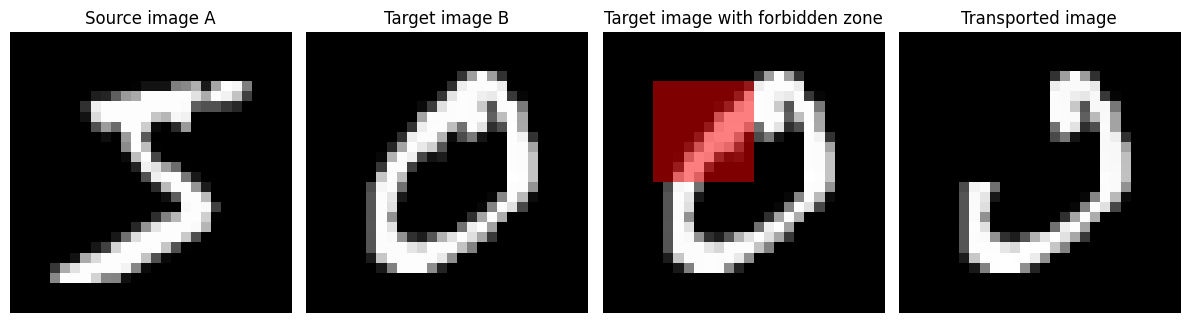

In [24]:
check_constraint(P=P, D=D)
img_out = (P.T @ r).reshape((28, 28))
plot_images(A, B, img_out)

As we can see, the constraint is satisfied as the transported image does not contain any pixel in the forbidden zone. This is confirmed by the value of $ P \cdot D $ which is almost equal to 0.0.